# Download a chunk of an ITS_LIVE datacube, invert for average velocities between each satellite observation

requires datacube_tools.py in directory with notebook.  
https://github.com/nasa-jpl/its_live/blob/main/notebooks/datacube_tools.py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg
import scipy.sparse
from tqdm import tqdm
import xarray

import datacube_tools

## Grab ITS_LIVE data cube

In [2]:
xy = (-3306587.5, 254507.5)  # EPSG 3413 coordinate for center point
dc = datacube_tools.DATACUBETOOLS()
xfull, xsub, xy = dc.get_subcube_around_point(xy, "3413", half_distance=10000, variables=["v", "satellite_img1", "satellite_img2", "acquisition_date_img1", "acquisition_date_img2"])

# To save the ITS_LIVE datacube
#xsub.to_netcdf("hubbard_itslive.nc")

original xy (-3306587.5, 254507.5) 3413 maps to datacube (-3306587.5, 254507.5) EPSG:3413
subset and load at  31.33 seconds


## Set up variables to use in inversion

In [3]:
# Build up mask

# Remove all-nan timesteps
mask = np.logical_not(np.isnan(np.nanmean(np.nanmean(xsub.v, axis=1), axis=1)))

# Sentinel 1A
mask = np.logical_and(mask, np.logical_and(xsub.satellite_img1 == "1A", xsub.satellite_img2 == "1A"))

# After 2017-10
tcut = np.datetime64("2017-10-01")
mask = np.logical_and(mask, xsub.acquisition_date_img1 >= tcut)

# Before 2019-10
tcut = np.datetime64("2018-10-01")
mask = np.logical_and(mask, xsub.acquisition_date_img2 <= tcut)

# Apply mask to velocities
v = xsub.v[:][mask]

# Find timesteps
ns_in_day = 1e9*60*60*24
epoch = np.datetime64("2000-01-01T00:00:00.000000000")
    
aq1 = ((xsub.acquisition_date_img1[mask]-epoch).to_numpy()/ns_in_day).astype(np.float32)
aq2 = ((xsub.acquisition_date_img2[mask]-epoch).to_numpy()/ns_in_day).astype(np.float32)

uniq_aq = np.unique(np.append(aq1, aq2))
diff_aq = np.diff(uniq_aq)

# Solution dates
solu = (uniq_aq[1:] + uniq_aq[:-1])/2

# Inversion results container
v_inv = np.zeros((solu.shape[0], v.shape[1], v.shape[2]))

/tmp/ipykernel_17566/3940706865.py:4: RuntimeWarning: Mean of empty slice
  mask = np.logical_not(np.isnan(np.nanmean(np.nanmean(xsub.v, axis=1), axis=1)))


## Inversion

In [4]:
# Loop over pixels in image, invert for velocity in each.
alpha = 200 # Strength of time regularization
beta = 50 # Strength of space regularization

for i in tqdm(range(1, v.shape[1]-1)):
    for j in range(1, v.shape[2]-1):
        As = []
        bs = []

        # Displacement equations
        for vsub in [v[:,i,j], v[:,i-1,j], v[:,i,j-1], v[:,i,j+1], v[:,i+1,j]]:
            # Nan mask for pixel
            #mask = np.logical_and(np.logical_not(np.isnan(vsub)), vsub.values>100)
            mask = np.logical_not(np.isnan(vsub))
            
            vsub = vsub[mask]
            A = np.zeros((len(vsub), len(diff_aq)), dtype=np.float32)
            aq1sub = aq1[mask]
            aq2sub = aq2[mask]

            for k in range(len(vsub)):
                k0 = np.where(aq1sub[k] == uniq_aq)[0][0]
                k1 = np.where(aq2sub[k] == uniq_aq)[0][0]
                A[k, k0:k1] = diff_aq[k0:k1]

            tstep = aq2sub-aq1sub
            As.append(A)
            bs.append((vsub*tstep).to_numpy())


        dts = []
        # Forward difference in time
        for A in As:
            dt = np.zeros((len(diff_aq)-1, len(diff_aq)))
            for k in range(len(diff_aq)-1):
                dt[k,k] = -alpha/diff_aq[k]
                dt[k,k+1] = alpha/diff_aq[k]

            dts.append(dt)

        # Probably a better way to do the differences in space
        # this is a lot of nearly identical for loops
        # Left difference in space
        dxf = np.zeros((len(diff_aq)-1,len(As)*As[0].shape[1]))
        mbase = As[0].shape[1]
        mstep = -As[0].shape[1]
        for k in range(len(diff_aq)-1):
            dxf[k,mbase+k] = -beta
            dxf[k,mbase+mstep+k] = beta

        # Right difference in space
        dxr = np.zeros((len(diff_aq)-1,len(As)*As[0].shape[1]))
        mbase = As[0].shape[1]
        mstep = As[0].shape[1]
        for k in range(len(diff_aq)-1):
            dxr[k,mbase+k] = -beta
            dxr[k,mbase+mstep+k] = beta

        # Up difference in space
        dyf = np.zeros((len(diff_aq)-1,len(As)*As[0].shape[1]))
        mbase = As[0].shape[1]
        mstep = 2*As[0].shape[1]
        for k in range(len(diff_aq)-1):
            dyf[k,mbase+k] = -beta
            dyf[k,mbase+mstep+k] = beta

        # Down difference in space
        dyr = np.zeros((len(diff_aq)-1,len(As)*As[0].shape[1]))
        mbase = As[0].shape[1]
        mstep = 3*As[0].shape[1]
        for k in range(len(diff_aq)-1):
            dyr[k,mbase+k] = -beta
            dyr[k,mbase+mstep+k] = beta

        # Stack spatial derivative matrices
        dxy = np.vstack([dxf,dxr,dyf,dyr])
        
        # Assemble matrices
        n = 0
        for A in As:
            n += A.shape[0]

        n += len(dts)*dts[0].shape[0]
        n += dxy.shape[0]

        m = len(As)*As[0].shape[1]

        B = np.zeros((n,m), dtype=np.float32)

        # Insert displacement equations
        ni = 0
        mi = 0

        for A in As:
            B[ni:ni+A.shape[0], mi:mi+A.shape[1]] = A
            ni += A.shape[0]
            mi += A.shape[1]

        # Insert forward difference
        mi = 0
        for dt in dts:
            B[ni:ni+dt.shape[0], mi:mi+dt.shape[1]] = dt
            ni += dt.shape[0]
            mi += dt.shape[1]

        B[ni:ni+dxy.shape[0], 0:dxy.shape[1]] = dxy

        # Build RHS
        c = np.concatenate(bs)
        c = np.append(c, np.zeros(len(dts)*dts[0].shape[0] + dxy.shape[0]))
        
        # Solve
        Bsp = scipy.sparse.coo_array(B)
        
        v_inv[:,i,j] = scipy.sparse.linalg.lsqr(Bsp, c)[0][:len(solu)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [05:12<00:00,  1.90s/it]


## Package and save results

In [5]:
td = np.array([np.timedelta64(int(t), "D") for t in solu])

xres = xarray.Dataset(
    data_vars = dict(
        speed=(["time", "y", "x"], v_inv),
    ),
    coords = dict(
        x = xsub.x,
        y = xsub.y,
        time = epoch+td,
    ),
    attrs = dict(
        projection = xsub.projection,
        GDAL_AREA_OR_POINT = xsub.GDAL_AREA_OR_POINT,
    ))

xres.to_netcdf("hubbard.nc")

## Plot results

Text(0, 0.5, 'i')

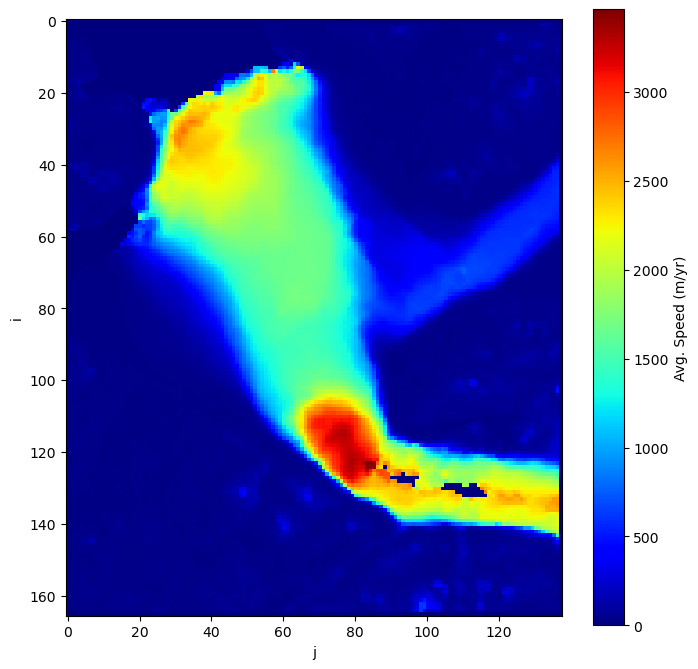

In [6]:
# Plot avg speed
plt.figure(figsize=(8,8))
plt.imshow(np.nanmean(v_inv, axis=0), cmap="jet")
plt.colorbar(label="Avg. Speed (m/yr)")
plt.xlabel("j")
plt.ylabel("i")

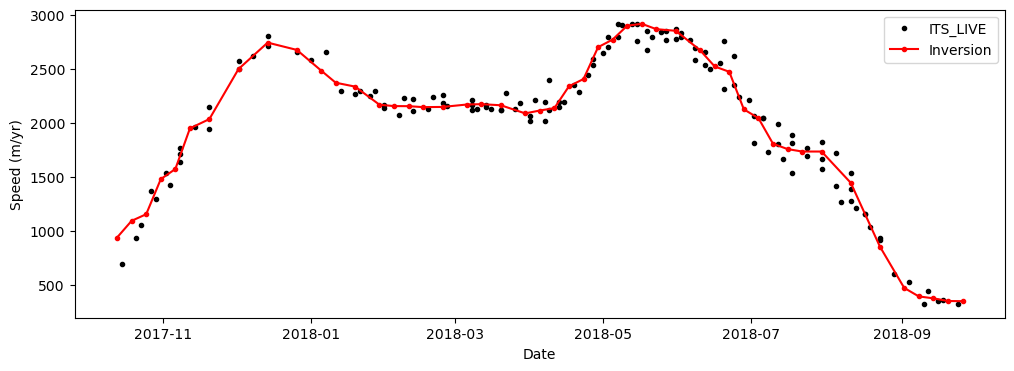

In [7]:
# Plot single point
i, j = (35, 50)

# For plotting its_live data
itsl_mask = np.logical_not(np.isnan(v[:,i,j]))
aq1sub = aq1[itsl_mask]
aq2sub = aq2[itsl_mask]
md = (aq2sub+aq1sub)/2

# Convert to datetime
md = epoch+np.array([np.timedelta64(int(t*60*60*24), "s") for t in md])
solud = epoch+np.array([np.timedelta64(int(t*60*60*24), "s") for t in solu])

plt.figure(figsize=(12,4))
plt.plot(md, v[itsl_mask,i,j], 'k.', label="ITS_LIVE")
plt.plot(solud, v_inv[:,i,j], 'r.-', label="Inversion")
plt.xlabel("Date")
plt.ylabel("Speed (m/yr)")
plt.legend()